# Starting Off

Imagine you are a financial analyst who wants to try and predict the price of a stock (Apple for example) for the next 10 days. What pieces of information(features) whould you think woudl be helpful in trying to forecast the price of the stock?



# Time Series Analysis: SARIMA Model

## Agenda:
- Working with time series data in pandas
- Components of time series data
- Stationarity
- ACF and PACF
- Fitting the Model
- Evaluating the Model


The methods of analysis and prediction dealing with data that is serially correlated is **Times Series Modeling**

A time series is a sequential set of data points, measured typically over successive times. It is mathematically defined as a set of vectors $$x_t$$ $$t = 0,1,2,...$$ where $t$ represents the time
elapsed [21, 23, 31]. The variable $x_t$ is treated as a random variable. The measurements
taken during an event in a time series are arranged in a proper chronological order.

**Regression formula**:<br>
$$ŷ_t   =   μ + ϕ_1 y_{t-1} +…+ ϕ_p y_{t-p} - θ_1e_{t-1} -…- θ_qe_{t-q}$$

### Steps to modeling time series data
![steps](./resources/flowchart.png)


[Duke ARIMA documentaion](https://people.duke.edu/~rnau/411arim.htm)

In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import statsmodels.api as sm


In [2]:
df=pd.read_csv('./resources/Sales_Data.csv', sep='\t', index_col=0)
df.head()

,purchase_date,payment_amount
ID,,
1003459795,2010-01-01 00:00:00,1779.0
1003462096,2010-01-03 00:00:00,2374.0
1003464028,2010-01-04 00:00:00,1449.0
1003464770,2010-01-04 00:00:00,2204.0
1003464895,2010-01-04 00:00:00,450.0


In [3]:
df.dtypes

purchase_date      object
payment_amount    float64
dtype: object

In [4]:
df['purchase_date']= pd.to_datetime(df['purchase_date']) 

In [5]:
df.head()

,purchase_date,payment_amount
ID,,
1003459795,2010-01-01,1779.0
1003462096,2010-01-03,2374.0
1003464028,2010-01-04,1449.0
1003464770,2010-01-04,2204.0
1003464895,2010-01-04,450.0


In [6]:
df.dtypes

purchase_date     datetime64[ns]
payment_amount           float64
dtype: object

In [7]:
df = df[df['payment_amount']>100]


In [8]:
daily_sales = df.groupby(['purchase_date'])['payment_amount'].sum()

In [9]:
daily_sales.head()

purchase_date
2010-01-01      6456.0
2010-01-02     37953.1
2010-01-03     59445.4
2010-01-04    142296.7
2010-01-05    117510.4
Name: payment_amount, dtype: float64

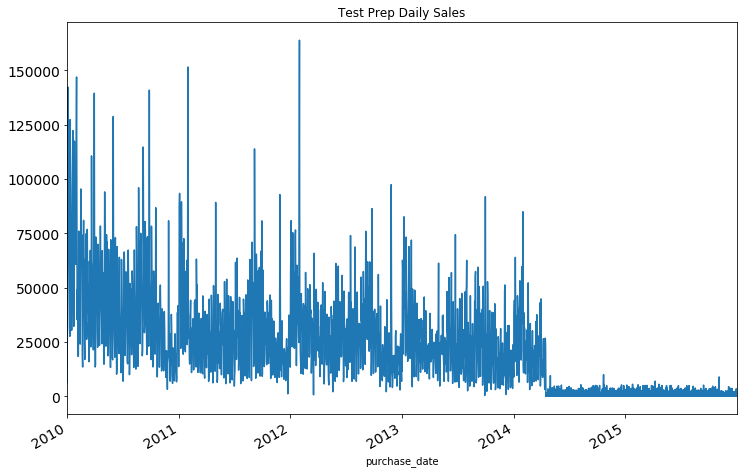

In [10]:
daily_sales.plot(figsize=(12,8), title= 'Test Prep Daily Sales', fontsize=14)

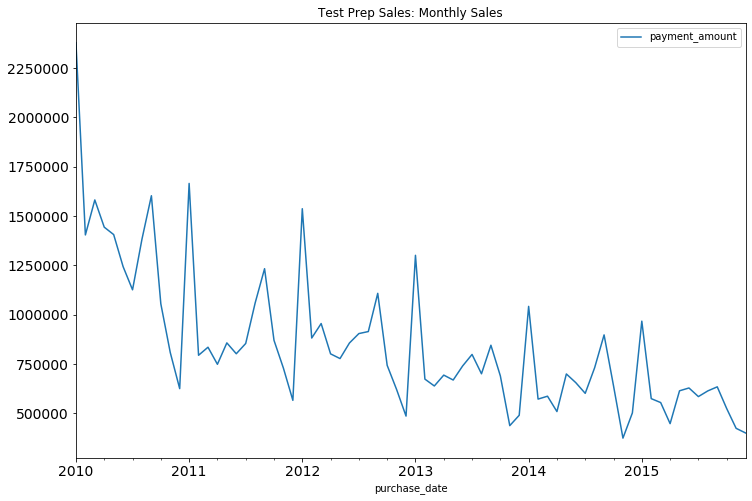

In [11]:
monthly_sales=daily_sales.resample('m').sum()
monthly_sales  = pd.DataFrame(monthly_sales, columns=['payment_amount'])
monthly_sales.plot(figsize=(12,8), title= 'Test Prep Sales: Monthly Sales', fontsize=14)

### Components of Time Series Data
A time series in general is supposed to be affected by four main components, which can be separated from the observed data. These components are: *Trend, Cyclical, Seasonal and Irregular* components.

- **Trend** : The long term movement of a time series. For example, series relating to population growth, number of houses in a city etc. show upward trend.
- **Seasonality** : Fluctuation in the data set that follow a regular pattern due to outside influences. For example sales of ice-cream increase in summer, or daily web traffic.
- **Cyclical** : When data exhibit rises and falls that are not of fixed period.  Think of business cycles which usually last several years, but where the length of the current cycle is unknown beforehand.
- **Irregrular**: Are caused by unpredictable influences, which are not regular and also do not repeat in a particular pattern. These variations are caused by incidences such as war, strike, earthquake, flood, revolution, etc. There is no defined statistical technique for measuring random fluctuations in a time series.


*Note: Many people confuse cyclic behaviour with seasonal behaviour, but they are really quite different. If the fluctuations are not of fixed period then they are cyclic; if the period is unchanging and associated with some aspect of the calendar, then the pattern is seasonal.*

<Figure size 432x288 with 0 Axes>

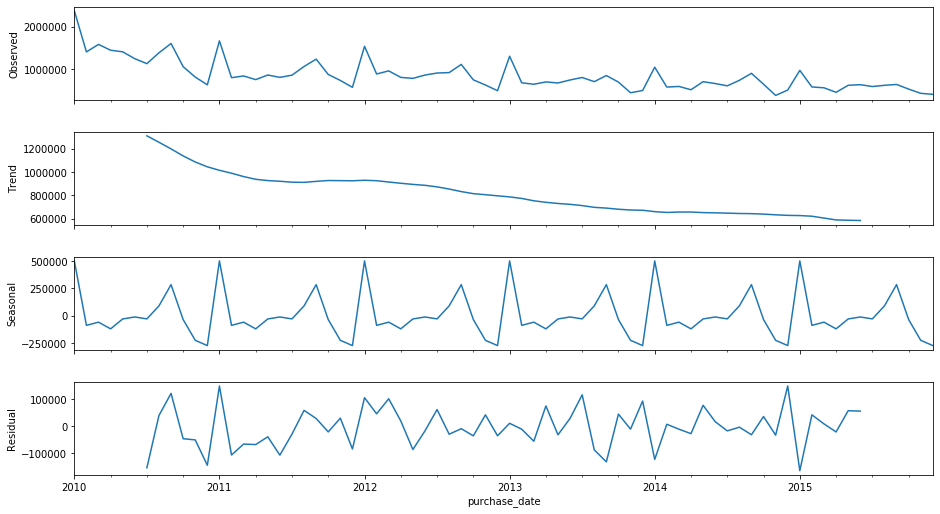

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(monthly_sales, freq=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

Why can't we use linear regression techniques to forecast for times Seriese data?



There are four principal assumptions which justify the use of linear regression models for purposes of inference or prediction:

- Linearity and additivity of the relationship between dependent and independent variables:

- Statistical independence of the errors (in particular, no correlation between consecutive errors in the case of time series data)

-  Homoscedasticity (constant variance) of the errors

- Normality of the error distribution.

### Statistical stationarity: 

A **stationary time series** is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past!  

### Visualizing Homoscedasticity:
    


#### Cosntant Mean

<img src='./resources/Mean_nonstationary.png' />

#### Constant Variance

<img src='./resources/Var_nonstationary.png' />

#### Autocovariance that does not depend on time.

<img src='./resources/Cov_nonstationary.png' />

## Two ways to check for stationarity

1. **Plot rolling Statistics**

    We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months.

2. **Dickey-Fuller Test**:
This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [28]:
monthly_sales.head()

,payment_amount
purchase_date,
2010-01-31,2378448.95
2010-02-28,1404627.65
2010-03-31,1581992.57
2010-04-30,1443978.55
2010-05-31,1406408.25


Resources on [Dicky-Fuller Test](https://nwfsc-timeseries.github.io/atsa-labs/sec-boxjenkins-aug-dickey-fuller.html)

In [29]:
from statsmodels.tsa.stattools import adfuller

#create a function that will help us to quickly 
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


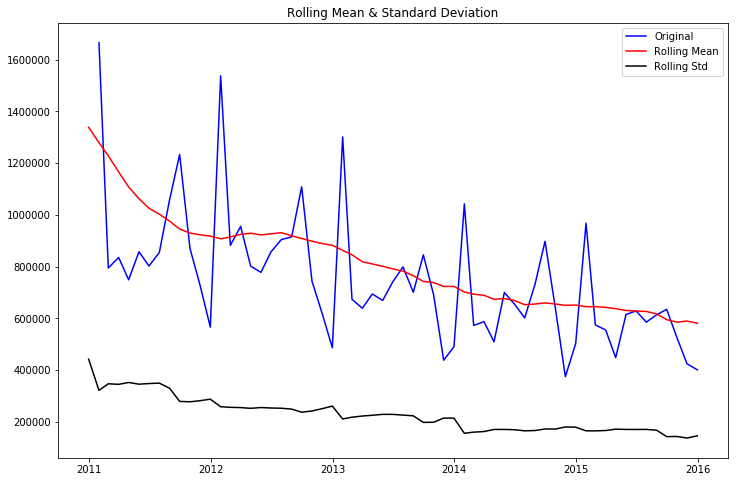

Results of Dickey-Fuller Test:
Test Statistic                 -1.446690
p-value                         0.559699
#Lags Used                     12.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [30]:
#test the stationarity of the untransformed dataset
test_stationarity(monthly_sales.payment_amount, 12)

### How to Stationarize time series data

- Log Transofrmation
- Deflating the data
- Differencing 

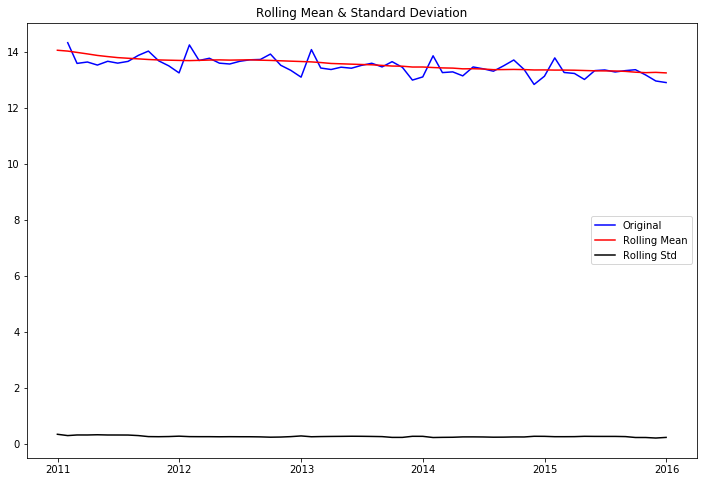

Results of Dickey-Fuller Test:
Test Statistic                 -1.231936
p-value                         0.659709
#Lags Used                     12.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [31]:

monthly_sales['natural_log'] = monthly_sales.payment_amount.apply(lambda x: np.log(x))  
test_stationarity(monthly_sales.natural_log, 12)

#### First Difference

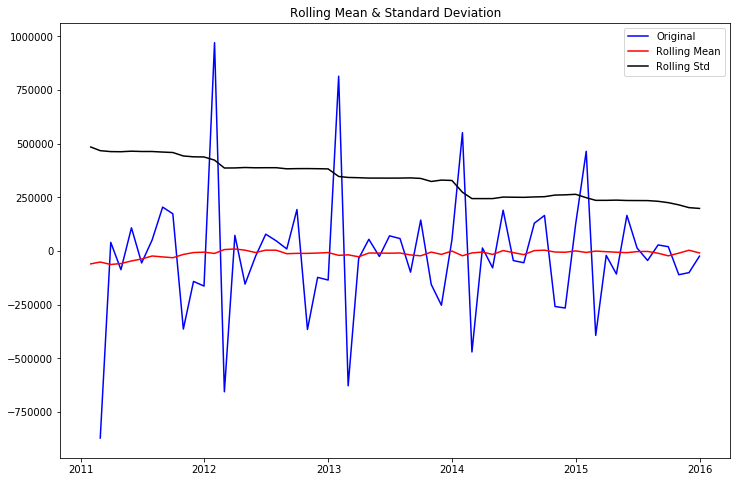

Results of Dickey-Fuller Test:
Test Statistic                 -2.775210
p-value                         0.061903
#Lags Used                     11.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [32]:
monthly_sales['first_difference'] = monthly_sales.payment_amount - monthly_sales.payment_amount.shift(1)  
test_stationarity(monthly_sales.first_difference.dropna(inplace=False),12)

#### Seasonal Difference

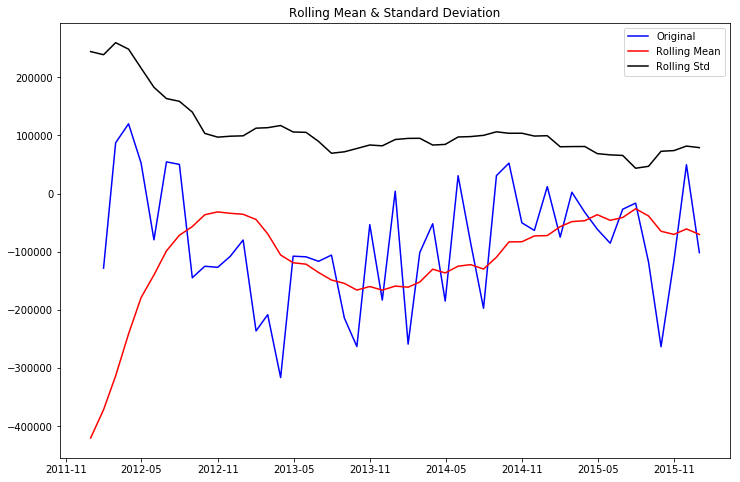

Results of Dickey-Fuller Test:
Test Statistic                 -3.533760
p-value                         0.007161
#Lags Used                      0.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [35]:
monthly_sales['seasonal_difference'] = monthly_sales.payment_amount - monthly_sales.payment_amount.shift(12)  
test_stationarity(monthly_sales.seasonal_difference.dropna(inplace=False), 12)

#### Seasonal Difference of the First Difference

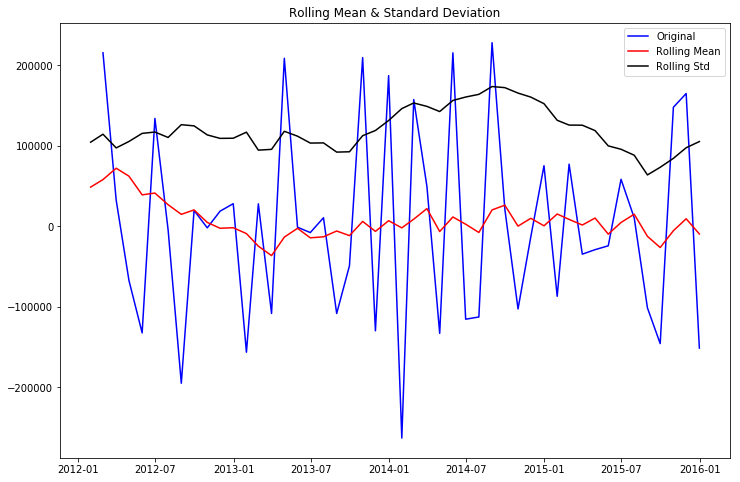

Results of Dickey-Fuller Test:
Test Statistic                -7.956275e+00
p-value                        3.031374e-12
#Lags Used                     1.000000e+00
Number of Observations Used    5.700000e+01
Critical Value (1%)           -3.550670e+00
Critical Value (5%)           -2.913766e+00
Critical Value (10%)          -2.594624e+00
dtype: float64


In [34]:
monthly_sales['seasonal_first_difference'] = monthly_sales.first_difference - monthly_sales.first_difference.shift(12)  
test_stationarity(monthly_sales.seasonal_first_difference.dropna(inplace=False), 12)

#### Season Difference of the log first difference

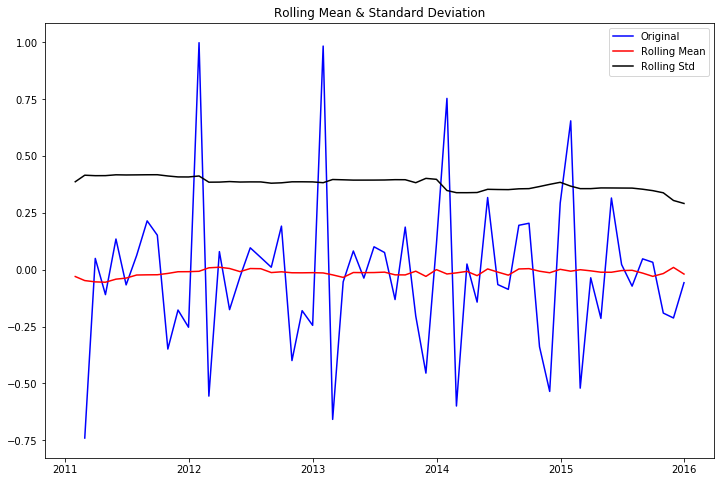

Results of Dickey-Fuller Test:
Test Statistic                 -3.224107
p-value                         0.018631
#Lags Used                     11.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [36]:
monthly_sales['log_first_difference'] = monthly_sales.natural_log - monthly_sales.natural_log.shift(1)  
monthly_sales['log_seasonal_first_difference'] = monthly_sales.log_first_difference - monthly_sales.log_first_difference.shift(12)  

test_stationarity(monthly_sales.log_first_difference.dropna(inplace=False), 12)


Sometimes, we have to difference the differenced data (known as a second difference) to achieve stationary data. The number of times we have to difference our data is the order of differencing - we will use this information when building our model.

### Autoregressive Integrated Moving Average  (ARIMA)

#### Autoregressive term

If the series is stationary and autocorrelated, perhaps it can be predicted as a multiple of its own previous value, plus a constant.  The forecasting equation in this case is:


$$Ŷt  =  μ  +  ϕ_1Y_{t-1}$$

…which is Y regressed on itself lagged by one period. 

####  Moving Average term

Another strategy for correcting autocorrelated errors is to use an average of the last few observations in order to filter out the noise and more accurately estimate the local mean. one of which is the so-called “error correction” form, in which the previous forecast is adjusted in the direction of the error it made:

$$Ŷ_t   =  Ŷ_{t-1}  + αe_{t-1}$$  

Because $e_{t-1} = Y_{t-1} - Ŷ_{t-1}$ by definition, this can be rewritten as:

$$Ŷ_t   =  Y_{t-1}  - (1-α)e_{t-1}$$

$$Ŷ_t =  Y_{t-1}  - θ_1e_{t-1}$$



#### Integrated


A seasonal ARIMA model is classified as an **ARIMA(p,d,q)x(P,D,Q)** model, 

    **p** = number of autoregressive (AR) terms 
    **d** = number of differences 
    **q** = number of moving average (MA) terms
     
    **P** = number of seasonal autoregressive (SAR) terms 
    **D** = number of seasonal differences 
    **Q** = number of seasonal moving average (SMA) terms

One we have achieved stationarity the next step in fitting a model to address any autocorrelation that remains in the differenced series.

## Plot ACF/PACF charts and find optimal parameters.

### Partial autocorrelation 

It is the correlation between a point and particular lag without the influence of itermediary lags. This helps us see the direct relationship between certain lags.

## ACF and PACF

#### on original data

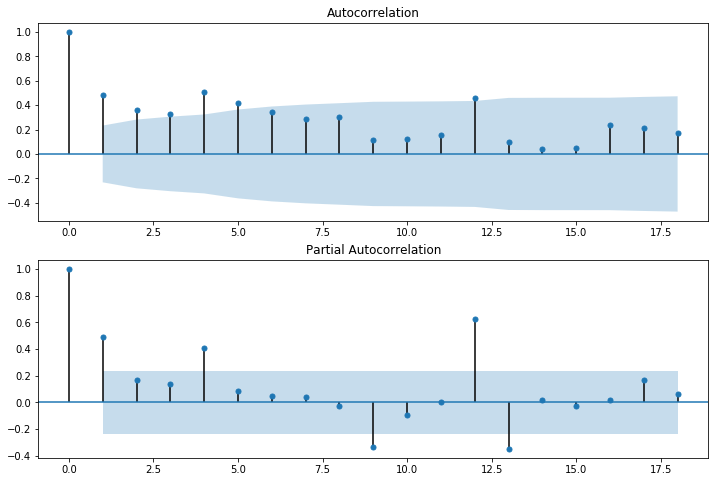

In [37]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.payment_amount.iloc[1:], lags=18, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.payment_amount.iloc[1:], lags=18, ax=ax2)

#### on first difference

/Users/apeeblesmadigan/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


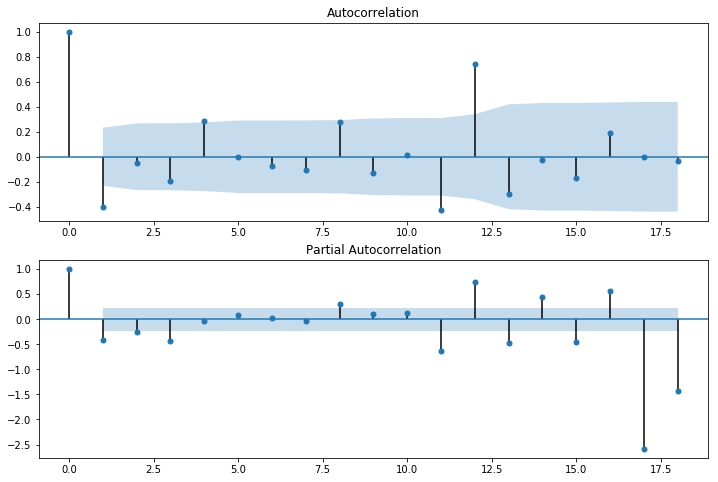

In [38]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.first_difference.iloc[1:], lags=18, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.first_difference.iloc[1:], lags=18, ax=ax2)

#### on seasonal first difference

/Users/apeeblesmadigan/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


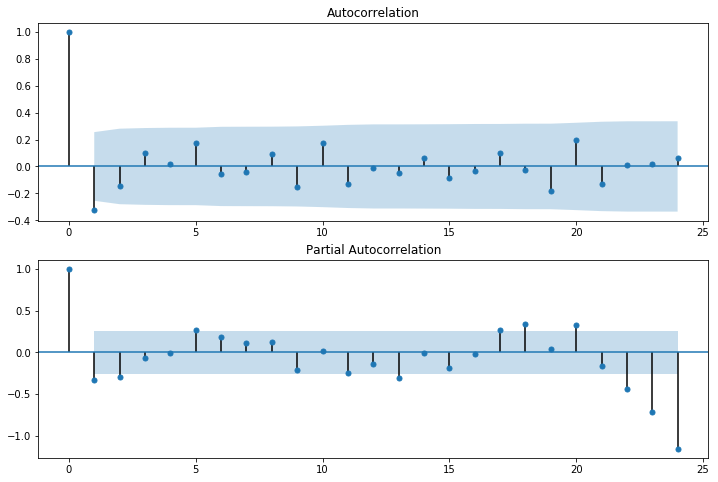

In [39]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.seasonal_first_difference.iloc[13:], lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.seasonal_first_difference.iloc[13:], lags=24, ax=ax2)

Since there is still some correlation between the times series data, we want to include terms that will account for this correlation. 



#### Determinging AR and MA terms


What’s the best way to correct for autocorrelation: 
- adding AR terms or 
- adding MA terms?  

A rule-of-thumb for this situation, which will be discussed in more detail later on, is that positive autocorrelation is usually best treated by adding an AR term to the model and negative autocorrelation is usually best treated by adding an MA term. 


![alt text](./resources/armaguidelines.png)

#### Rules for Indentifying ARIMA Models

https://people.duke.edu/~rnau/arimrule.htm

## Fitting the Model

`sm.tsa.statespace.SARIMAX()`
[SARIMAX documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)

In [14]:
mod = sm.tsa.statespace.SARIMAX(monthly_sales['payment_amount'], trend='n', order=(0,1,1), seasonal_order=(0,1,1,12))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                     payment_amount   No. Observations:                   72
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -771.166
Date:                            Wed, 04 Sep 2019   AIC                           1548.332
Time:                                    13:01:08   BIC                           1554.565
Sample:                                01-31-2010   HQIC                          1550.765
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1423      0.066     -2.170      0.030      -0.271      -0.014
ma.S.L12      -0.0554      0.061     -0.912      0.362      -0.174       0.064
sigma2      1.244e+10   2.97e-13    4.2e+22      0.000    1.24e+10    1.24e+10
===================================================================================
Ljung-Box (Q):                       33.32   Jarque-Bera (JB):                 1.93
Prob(Q):                              0.76   Prob(JB):                         0.38
Heteroskedasticity (H):               0.84   Skew:                             0.07
Prob(H) (two-sided):                  0.71   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.21e+38. Standard errors may be unstable.
"""

## Evaluating a Time Series Model

Can we use test train split when evaluating this model? 

<img src='https://people.duke.edu/~rnau/randwkf2.gif' width=700 />

-  The data in the **estimation period** are used to help select the model and to estimate its parameters. Forecasts made in this period are not completely "honest" because data on both sides of each observation are used to help determine the forecast. 

- The data in the **validation period** are held out during parameter estimation, and if you are careful you will also withhold these values during the exploratory phase of analysis when you select your model. One-step-ahead forecasts made in this period are often called backtests. Ideally, these are "honest" forecasts, however, if you test a great number of models and choose the model whose errors are smallest in the validation period, you may end up overfitting the data within the validation period as well as in the estimation period.

- **Forecasts into the future** are "true" forecasts that are made for time periods beyond the end of the available data. For a model which is purely extrapolative in nature , it is possible to extend the forecasts an arbitrary number of periods into the future by "bootstrapping" the model: first a one-period-ahead forecast is made, then the one-period-ahead forecast is treated as a data point and the model is cranked ahead to produce a two-period-ahead forecast, and so on as far as you wish.

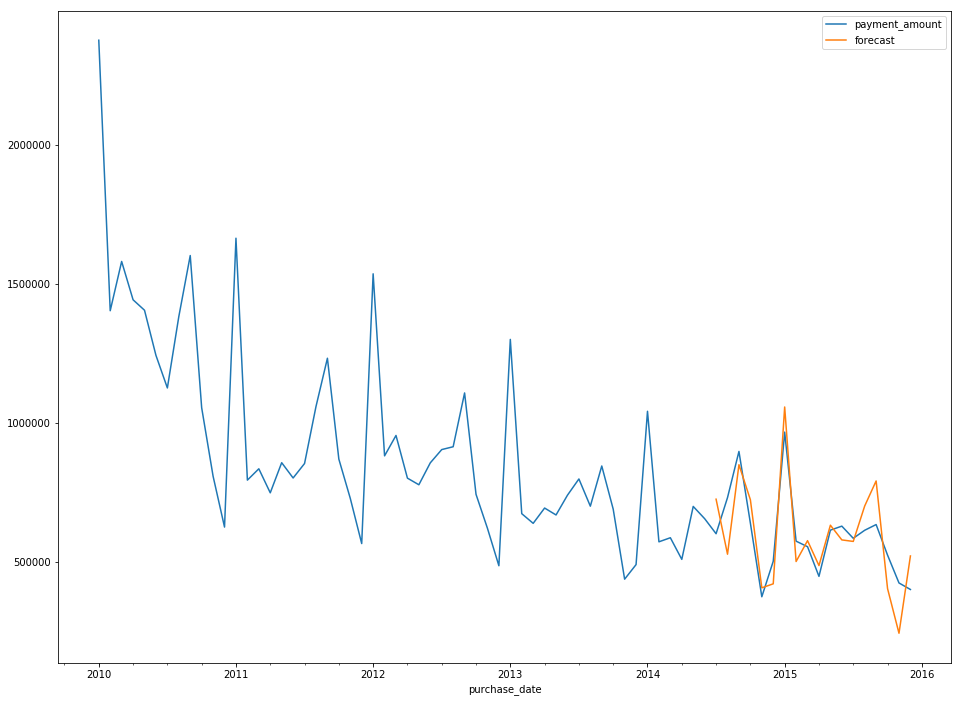

In [42]:
monthly_sales['forecast'] = res.predict(start = 54, end= 72, dynamic= False)  
monthly_sales[['payment_amount', 'forecast']].plot(figsize=(16, 12)) 

/Users/apeeblesmadigan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
/Users/apeeblesmadigan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


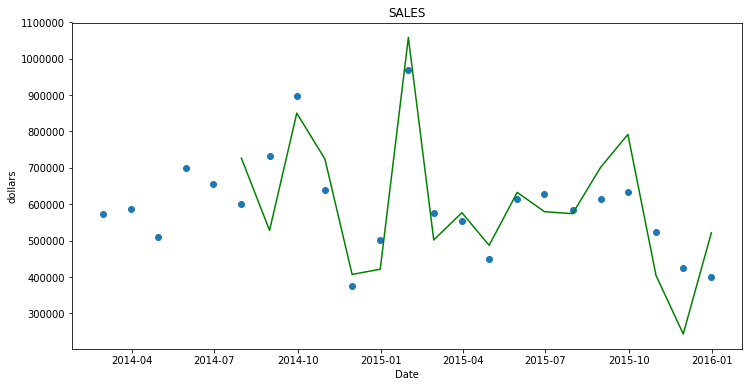

In [43]:
npredict =monthly_sales.payment_amount['2015'].shape[0]
nobs = monthly_sales.payment_amount.shape[0]



 
# Graph
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='SALES', xlabel='Date', ylabel='dollars')
ax.plot(monthly_sales.index[-npredict-npre+1:], monthly_sales.ix[-npredict-npre+1:, 'payment_amount'], 'o', label='Observed')
ax.plot(monthly_sales.index[-npredict-npre+1:], monthly_sales.ix[-npredict-npre+1:, 'forecast'], 'g', label='Dynamic forecast')


### Mean Absolute Error per prediction

In [44]:
np.abs(monthly_sales['2015']['payment_amount']- monthly_sales['2015']['forecast']).sum()/len(monthly_sales['2015'])

80777.75942811555

## Now let's predict all of 2016

In order for this to work, we need to extend our current data frame to account for the future time periods we will predict on.

In [45]:
from dateutil.relativedelta import relativedelta

start = datetime.datetime.strptime("2016-01-31", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= monthly_sales.columns)
monthly_sales = pd.concat([monthly_sales, future])

In [ ]:
#res.predict)

/Users/apeeblesmadigan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


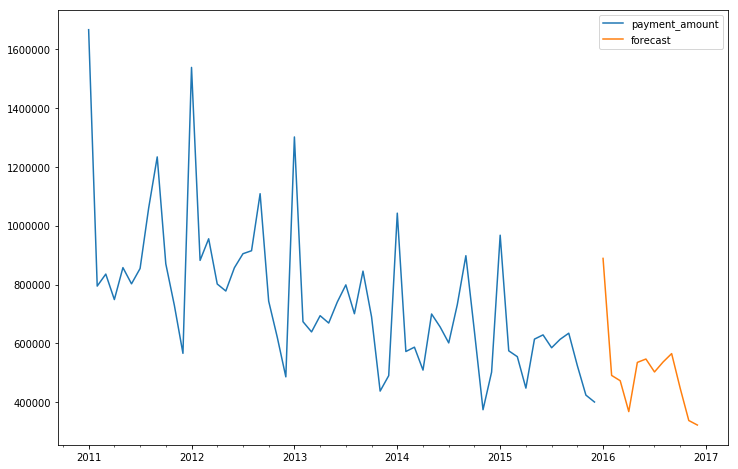

In [47]:
monthly_sales['forecast'] = res.predict(start = 72, end = 84, dynamic= True)  
monthly_sales[['payment_amount', 'forecast']].ix[-72:].plot(figsize=(12, 8)) 
plt.savefig('ts_predict_future.png', bbox_inches='tight')

### Steps to modeling time series data
![steps](./resources/flowchart.png)

## Application practice with dataset of trasit riders in Portland

In [ ]:
df = pd.read_csv('./resources/portland-oregon-average-monthly-.csv', index_col=0)
df.index.name=None
df.reset_index(inplace=True)
df.drop(df.index[114], inplace=True)

### Other resources
- [good kaggle tutorial](https://www.kaggle.com/poiupoiu/how-to-use-sarimax)
- [standford paper](http://cs229.stanford.edu/proj2015/219_report.pdf)